In [36]:
import torch
from torch.autograd import Variable
from torch import nn, optim
import numpy as np
import matplotlib as mpt
from matplotlib import pyplot as plt
from matplotlib import image as matImg
import os 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as trf
%matplotlib inline

### 准备数据

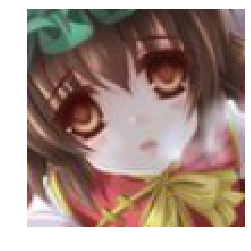

In [6]:
### 读取文件夹下所有文件
from matplotlib import image as matImg 
x = "./faces/0000fdee4208b8b7e12074c920bc6166-0.jpg"
def read_img(path):
    return matImg.imread(path)
plt.axis("off")
plt.imshow(read_img(x))

In [7]:
# 获取图片的路径
def get_img_path(path):
    ls = os.listdir(path)
    ls = [path+"/"+x for x in ls]
    return ls

In [8]:
# 读取所有图片
import os
from matplotlib import image as matImg
path = "./faces"
def load_data(path):
    img_path = get_img_path(path) # 将文件夹下所有图片的路径存入list中
    return [read_img(x) for x in img_path] # 通过路径读取每个图片，以np.array存入list
#     print((img_path[0]))
data = load_data(path)

In [19]:
type(data)

list

###  生成训练数据迭代器

In [127]:
class dataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        img = self.data[index]
        if self.transform is not None:
            img = self.transform(img)
        return img
transforms = trf.Compose([
    trf.ToTensor(),
    trf.Normalize([0.5]*3, [0.5]*3)
])
dset = dataset(data, transforms)
dload = DataLoader(dset, shuffle=True, batch_size=model_param.batch_size)
dload.__iter__().__next__().shape

torch.Size([128, 3, 96, 96])

### 模型超参数

In [155]:
class Param:
    def __init__(self):
        ## 数据处理
        self.path = "./faces"
        self.batch_size = 128
        self.img_size = 96
        ## 随机噪声数据生成
        self.noise = 128
        ## 生成器
        
        ## 判别器
        
        ## 优化
        self.learning_rate = 2e-4
        self.betas=(0.5, 0.999)
        ## 模型训练
        self.epochs = 10000
        ## 画图
        self.interval = 50
model_param = Param()

### 生成器 ：根据随机噪声输入 得到对应输出数据

In [136]:
class Generator(nn.Module):
    def __init__(self, in_dim):
        super(Generator, self).__init__()
        self.init_size = model_param.img_size
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 1024),
            nn.ReLU(True),
            nn.BatchNorm1d(1024),
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], )
        x = self.conv(x)
        return x
G = Generator(model_param.noise)

### 判别器: 输出输入数据的判别分数

In [103]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.img_size = model_param.img_size
        self.fc = nn.Sequential(
            nn.Linear(self.img_size**2, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return fc(x)
D = Discriminator()

### 判别器损失值计算
D（x）为判别器的输出值， 同时将生成器数据和真实数据做判断    
Max-> Loss = ∑x～Pdata(x){㏒D(x)} + ∑x～Pg(x){㏒(1-D(x))}


In [104]:
def Discrim_Loss(real_score, fake_score):
    loss = 0.5*((real_score - 1) ** 2).mean() + 0.5*( fake_score ** 2).mean()
    return loss

### 生成器损失值计算

1. Loss的计算同上，Min -> Loss，目标策略是最小化Loss
2. 但是训练生成器的时候，并不改变判别器的参数，也就是说Loss表达式中的第一项的值并不会随着G的优化而改变 所以：

    Min -> Loss = ∑x～Pg(x){㏒(1-D(x))}

In [138]:
def Gen_Loss(fake_score):
    loss = 0.5*((fake_score - 1) ** 2).mean()
    return loss

### 模型优化算法
1. real_img 和 fake_image 通过判别器后分别得到各自的D（x）
2. 再通过损失值函数算出Loss ,通过Loss去优化模型


In [111]:
G_optim = optim.Adam(G.parameters(), lr=model_param.learning_rate, betas=model_param.betas)

In [112]:
D_optim = optim.Adam(G.parameters(), lr=model_param.learning_rate, betas=model_param.betas)

### 模型的训练

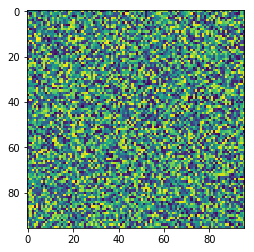

In [153]:
y = (torch.rand(96, 96) - 0.5) / 0.5
plt.imshow(y.numpy())

In [154]:
cnt = 0
for epoch in range(model_param.epochs):
    for imgs in dload:
        batch = imgs.shape[0]
        real_img = imgs
        sample_nois = (torch.rand(batch, model_param.noise) - 0.5) / 0.5
        fake_img = G(sample_nois)
        
        ## train D
        real_score = D(real_img)
        fake_score = D(fake_img)
        D_loss = Discrim_Loss(real_score, fake_score)
        
        D_optim.zero_grad()
        D_loss.backward()
        D_optim.step()
        
        ## train G
        fake_img = G(sample_nois)
        fake_score = D(fake_img)
        G_loss = Gen_Loss(fake_score)
        
        G_optim.zero_grad()
        G_loss.backward()
        G_optim.step()
        # update
        cnt+=1
        if cnt % model_param.interval == 0:
            plt.axis("off")
            plt.imshow(fake_img[0].numpy())

RuntimeError: size mismatch, m1: [128 x 128], m2: [1024 x 1024] at c:\a\w\1\s\tmp_conda_3.6_105809\conda\conda-bld\pytorch_1544094150554\work\aten\src\th\generic/THTensorMath.cpp:940